In [4]:
%load_ext autoreload
%autoreload 1
%aimport dlqmc.nn, dlqmc.sampling, dlqmc.utils
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = \
    {'bbox_inches': 'tight', 'dpi': 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import numpy as np
from scipy import special
import scipy.stats as sps
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.distributions import Normal
from pyscf import gto, scf, dft
import pyscf
from pyscf.data.nist import BOHR

from dlqmc.nn import WFNet
import dlqmc.nn
from dlqmc.sampling import langevin_monte_carlo, hmc ,samples_from
from dlqmc.utils import (
    plot_func, get_flat_mesh, assign_where, plot_func_xy,
    plot_func_x, integrate_on_mesh, form_geom, assign_where
)
from dlqmc.physics import (
    local_energy, grad, quantum_force,nuclear_potential,
    nuclear_energy
)
from dlqmc.gto import GTOWF
from dlqmc.analysis import autocorr_coeff, blocking
from dlqmc.nn import ssp

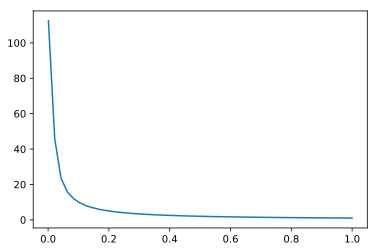

In [15]:
plot_func_x(lambda x: special.erf(x/0.01)/x,(1e-3, 1));

In [70]:
x_line = torch.cat((torch.linspace(-3, 3, 500)[:, None], torch.zeros((500, 2))), dim=1)
x_line=x_line.view(-1,1,3)
#mesh = get_3d_cube_mesh([(-6, 6), (-4, 4), (-4, 4)], [600, 400, 400])

In [17]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -0.60262227147977


-0.6026222714797698

## Net WF

In [18]:
#H2+     Energy = -0.6023424   for R = 1.9972
#fit(batch_size=10000, n_el=1, steps=500, epochs=1, RR=[[-1, 0, 0], [1., 0, 0]])

#H2		 Energy = -1.173427    for R = 1.40
#fit(batch_size=10000,n_el=2,steps=100,epochs=5,RR=torch.tensor([[-0.7,0,0],[0.7,0,0]]))

#He+	 Energy = -1.9998
#fit(batch_size=10000,n_el=1,steps=100,epochs=5,RR=torch.tensor([[0.,0,0]]),RR_charges=[2])

#He		 Energy = −2.90338583
#fit(batch_size=10000,n_el=2,steps=300,epochs=5,RR=torch.tensor([[0.3,0,0]]),RR_charges=[2])

In [29]:
h2p = form_geom([[-1., 0., 0.], [1., 0., 0.]], [1., 1.])
print(h2p)

ParameterDict(
    (charges): Parameter containing: [torch.FloatTensor of size 2]
    (coords): Parameter containing: [torch.FloatTensor of size 2x3]
)


In [79]:
import torch.nn as nn
class TestNet(nn.Module):
    def __init__(self, eps=0.01):
        super(TestNet, self).__init__()
        self.eps=eps
        self.NN1=nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 1)
            )
        self.NN2=nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 1)
            )
        self.alpha=nn.Parameter(torch.Tensor([10]))
        
    def forward(self,x,R=h2p.coords):
        if x.shape==(x.shape[0],3):
            x = x.view([-1,1,3])
        
        d = torch.zeros(len(x),2)
        d[:,0] = torch.norm(x-R[0],dim=[1,2])
        d[:,1] = torch.norm(x-R[1],dim=[1,2])
        r = torch.erf(d / self.eps) / d
        #return self.NN1(d).flatten()*(torch.exp(-torch.abs(self.alpha)*d[:,0])+torch.exp(-torch.abs(self.alpha)*d[:,1]))+ self.NN2(r).flatten()
        return self.NN1(d).flatten()*(torch.exp(-d[:,0])+torch.exp(-d[:,1]))+ self.NN2(r).flatten()


In [80]:
coords = torch.Tensor([[-1, 0, 0], [1, 0, 0]])
charges = torch.Tensor([1, 1])
lr = 5e-3

In [97]:
net = TestNet(eps=0.1)
opt = torch.optim.Adam(net.parameters(), lr=lr)
tape = []
tape_grad = []
tape_lap = []

#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.995)
scale=3
for i_step in range(0, 200):
    #scheduler.step()
    r = scale*torch.randn(2_000,1,3,requires_grad=True)
    pr = torch.from_numpy(sps.norm.pdf(np.linalg.norm(r.detach().numpy(),axis=1),scale=scale)).type(torch.FloatTensor)
    
    E_loc = local_energy(r,net,h2p)
    
    loss = torch.mean((E_loc[0]-0.5)**2)
 

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(),10)
    opt.step()
    opt.zero_grad()
    


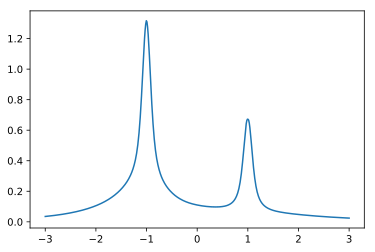

In [98]:
x_line.requires_grad = True
Psi2 = net(x_line, coords)**2
grad = torch.autograd.grad(Psi2,x_line,torch.ones_like(Psi2))[0]
plt.plot(x_line[:,0 , 0].detach().numpy(), Psi2.detach().numpy())
#plt.plot(x_line[:, 0].detach().numpy(), grad[:,0].detach().numpy())
#plt.ylim(-1,2)
x_line.requires_grad = False

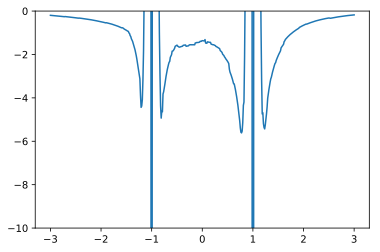

In [99]:
plt.plot(
    x_line[:, 0, 0].numpy(),
    local_energy(x_line,lambda x: net(x, coords), h2p)[0].detach().numpy()
)
plt.ylim((-10, 0));

In [106]:
samples = hmc(
    dist=lambda x: net(x, coords).squeeze()**2,
    stepsize=0.1,
    dysteps=3,
    n_walker=100,
    steps=5000,
    dim=3,
    startfactor=1,
    presteps=100,
).detach().reshape(-1, 3)

100%|██████████| 5100/5100 [01:02<00:00, 81.82it/s]

Acceptanceratio: 99.98%


In [169]:
sampler = langevin_monte_carlo(
    net,
    torch.randn(100, 1, 3, device='cpu'),
    tau=0.1,
)
samples = samples_from(sampler,range(1000))[0].view(-1,3)

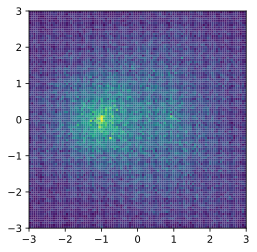

In [139]:
plt.hist2d(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [108]:
E_loc = local_energy(samples.view([-1,1,3]), lambda x: net(x, coords), h2p)[0]

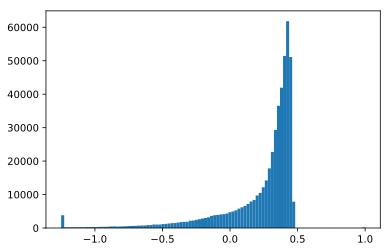

In [109]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [110]:
E_loc.mean().item()

0.22831200063228607